In [252]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
np.random.seed(2024)

In [119]:
dim = 1
n = 1000

x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [245]:
def mmd_experiment_single(kernel_class, Xs, Ys, theta, nboot=500, alpha=0.05, quantile=None):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot_oracle": {"val": [], "threshold": [], "pval": [], "rej": []},
        "boot": {"val": [], "threshold": [], "rej": [], "boot_stats": []},
        "boot_full": {"val": [], "threshold": [], "rej": [], "boot_stats": []},
        "simple": {"val": [], "threshold": [], "rej": []},
    }
    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        val = val**0.5
        threshold = mmd.test_threshold(X.shape[0])
        
        # 1. deviation bound
        rej = mmd.reverse_test(X, Y, theta, alpha)

        res["deviation"]["val"].append(val)
        res["deviation"]["threshold"].append(threshold)
        res["deviation"]["rej"].append(rej)

        # 2. bootstrap with ground truth quantile
        boot_rej = float(max(0, theta - val) > quantile)
        res["boot_oracle"]["val"].append(val)
        res["boot_oracle"]["rej"].append(boot_rej)
        res["boot_oracle"]["threshold"].append(quantile)

        # 3. bootstrap
        boot_stats = mmd.test_threshold(X.shape[0], X, nboot=nboot, method="bootstrap_efron")
        boot_stats = np.array(boot_stats)**0.5
        # TODO adjust by adding the original stat
        # boot_pval = np.sum((theta - val) <= boot_stats) / boot_stats.shape[0]
        # boot_rej = np.float32(boot_pval < alpha)

        quantile = np.quantile(boot_stats, 1 - alpha)
        boot_rej = float(max(0, theta - val) > quantile)
        
        res["boot"]["val"].append(val)
        res["boot"]["rej"].append(boot_rej)
        res["boot"]["threshold"].append(quantile)
        res["boot"]["boot_stats"].append(boot_stats)

        # 4. full bootstrap
        boot_stats = mmd.test_threshold(X.shape[0], X, Y=Y, nboot=nboot, method="bootstrap_efron_full")
        boot_stats = np.array(boot_stats)**0.5
        quantile = np.quantile(boot_stats, 1 - alpha)
        boot_rej = float(max(0, theta - val) > quantile)
        
        res["boot_full"]["val"].append(val)
        res["boot_full"]["rej"].append(boot_rej)
        res["boot_full"]["threshold"].append(quantile)
        res["boot_full"]["boot_stats"].append(boot_stats)

    return res

def mmd_experiment(kernel_class, Xs, Ys, theta, keys, nboot=500, quantiles=None):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    for Xs_i, Ys_i, kk, qq in zip(Xs, Ys, keys, quantiles):
        print("key:", kk)
        res[kk] = mmd_experiment_single(kernel_class, Xs_i, Ys_i, theta, nboot=nboot, quantile=qq)

    return res
    

In [187]:
def population_mmd(mean, bandwidth_sq):
    """Compute population MMD under a mean-shift Gaussians setup
    """
    d = mean.shape[-1]
    mean_norm_sq = np.sum(mean**2)
    mmd_sq = 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2) * (1 - np.exp(- mean_norm_sq / (2 * (2 + bandwidth_sq))))
    return mmd_sq**0.5

def population_mmd_inverse(val, d, bandwidth_sq):
    """Compute the \| \mu \|_2^2 required for the population MMD 
    under a mean-shift Gaussians setup to equal to a given value.
    """
    mmd_sq = val**2
    c = 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2)
    return -2. * (2 + bandwidth_sq) * np.log(1 - mmd_sq / c)

# Deviation bound

In [94]:
np.random.seed(2024)

In [95]:
nrep = 10
n = 1000
dim = 1
mean1 = np.zeros((dim,)) + 1. # data
mean2 = np.zeros((dim,)) # model

### Gaussian loc
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
###

kernel_class = kernels.RBF

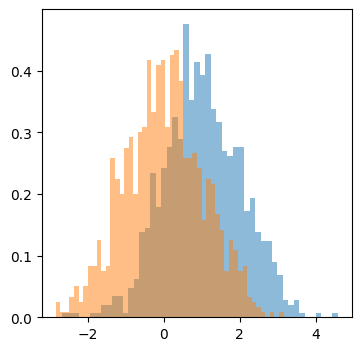

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [97]:
theta = 1.
res = mmd_experiment_single(kernel_class, Xs, Ys, theta=theta, nboot=500)

  0%|          | 0/10 [00:00<?, ?it/s]

In [98]:
res["deviation"]["val"]

[0.1720179636345991,
 0.18428476926383563,
 0.19582963197821102,
 0.16876194066065464,
 0.18649441828899527,
 0.17913646195417887,
 0.18342694734633536,
 0.1783882833690058,
 0.1668056666349813,
 0.17507306934642775]

In [109]:
np.sum((np.eye(dim)[:1, 0] * 1.)**2)

1.0

In [110]:
print(population_mmd(mean1, 1.))
print(np.mean(res["deviation"]["val"]))

0.17726763491986192
0.17902191524772246


In [111]:
population_mmd_inverse(population_mmd(mean1, 1.), dim, 1.)

0.9999999999999996

In [163]:
np.random.seed(2024)

In [164]:
nrep = 100
population_mmd_ls = [1e-1, 2e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 7.5e-1, 1.]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

kernel_class = kernels.RBF

keys = population_mmd_ls

In [165]:
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, nboot=500)

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.35


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.45


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.75


  0%|          | 0/100 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

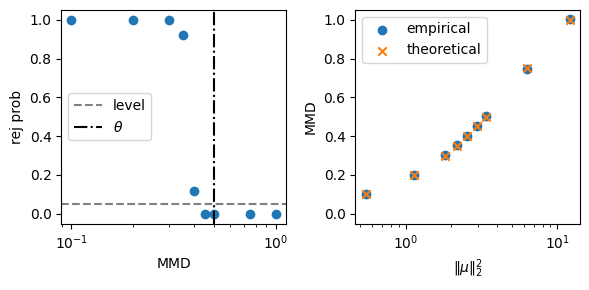

In [167]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, vals, label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()

# Bootstrap

In [120]:
np.random.seed(2024)

In [121]:
n = 1000
dim = 1
nrep = 100
# population_mmd_ls = [2e-1, 2.5e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 5.5e-1, 6e-1]
# population_mmd_ls = [4.8e-1, 4.9e-1, 4.95e-1, 5e-1, 5.05e-1, 5.1e-1, 5.2e-1, 5.3e-1]
population_mmd_ls = [2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1]
# population_mmd_ls = [3e-1, 4e-1, 5e-1, 6e-1]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []
quantiles = []
stats_all_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep*3, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs[:nrep])
    Ys_ls.append(Ys[:nrep])

    # compute true quantiles
    stat_ls = []
    kernel = kernels.RBF(sigma_sq=2.)
    mmd = metrics.MMD(kernel)
    # Xs = np.random.multivariate_normal(mean1, np.eye(dim), (1000*2, n))
    for i in trange(nrep):
    # for i in trange(1000):
        X, Y = Xs[nrep+i], Xs[2*nrep+i]
        # X, Y = Xs[i], Xs[nrep+i]
        stat_ls.append(mmd(X, Y)**0.5)

    quantile = np.quantile(stat_ls, 0.95)
    quantiles.append(quantile)
    stats_all_ls.append(stat_ls)
            
kernel_class = kernels.RBF

keys = population_mmd_ls

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

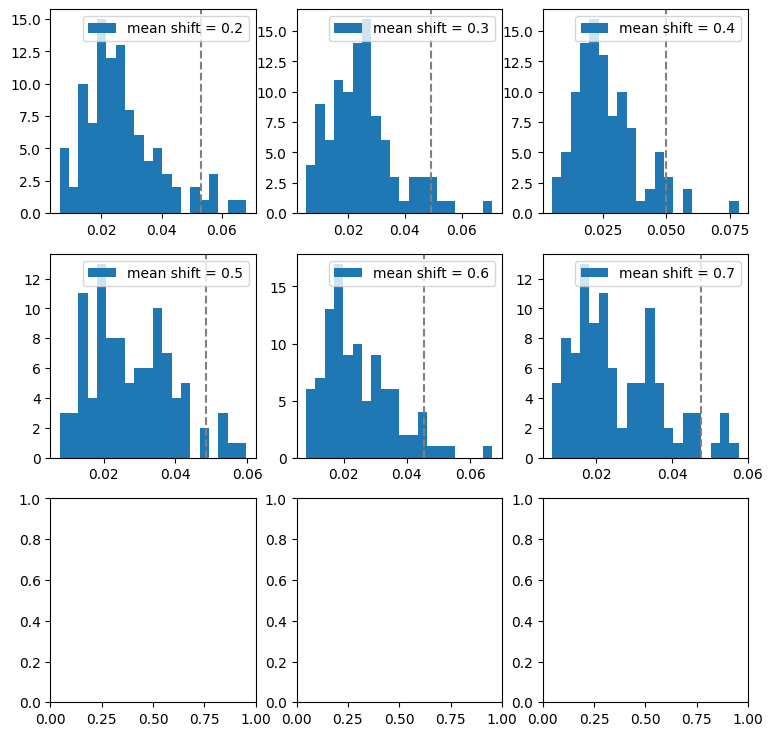

In [122]:
# true sampling distribution
figs, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i, ww in enumerate(population_mmd_ls):
    ax = axes.flatten()[i]
    ax.hist(stats_all_ls[i], bins=20, label=f"mean shift = {ww}")
    ax.axvline(quantiles[i], color="gray", linestyle="--")
    ax.legend()

In [126]:
np.random.seed(2024)

In [127]:
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, quantiles=quantiles)

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.6


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.7


  0%|          | 0/100 [00:00<?, ?it/s]

In [141]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
# ax.scatter(keys, rej_prob, label="Deviation")
# ax.axhline(0.05, color="grey", linestyle="--", label="level")
# ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# # ax.set_xscale("log")
# ax.set_ylim(-0.05, 1.05)
# ax.set_xlabel("MMD")
# ax.set_ylabel("Rejection probability")
# ax.legend()

# _ = plt.tight_layout()
# plt.tight_layout()
# # plt.savefig("../figs/reversed/ms.pdf")

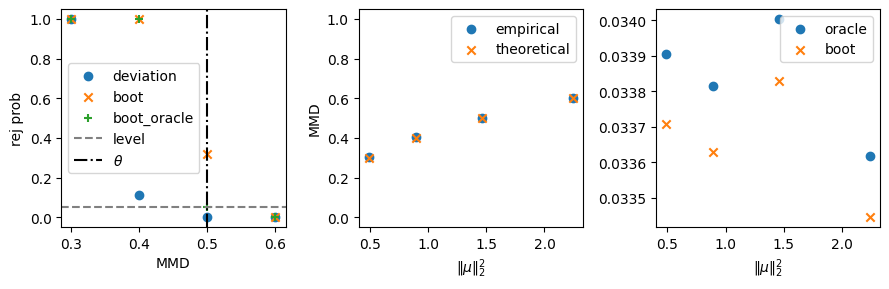

In [84]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_oracle")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv**0.5 for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

ax = axes[2]
quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
ax.scatter(shift_sq_ls, quantile_boot, marker="x", color="C1", label="boot")
ax.scatter(shift_sq_ls, quantile_oracle, marker="+", color="C2", label="oracle")
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

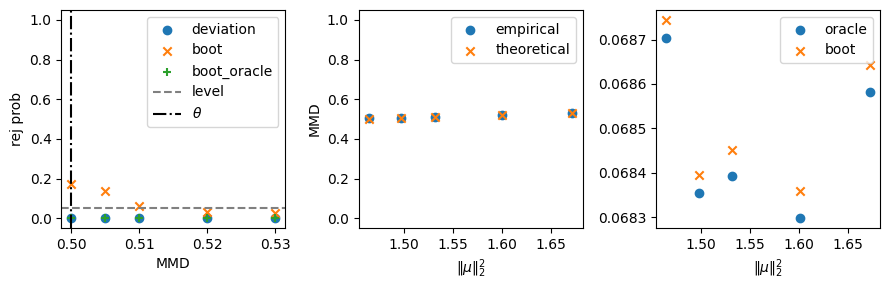

In [102]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_oracle")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv**0.5 for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

ax = axes[2]
quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
ax.scatter(shift_sq_ls, quantile_oracle, label="oracle")
ax.scatter(shift_sq_ls, quantile_boot, marker="x", label="boot")
# ax.set_xscale("log")
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

# Bootstrap debug

In [246]:
np.random.seed(2024)

In [247]:
n = 200 # 1000
dim = 1
nrep = 50
ora_size = 10000
nstats_ora = 100
population_mmd_ls = [0.2, 0.4, 0.45, 0.5, 0.55, 0.6]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []
quantiles = []
stats_all_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

    # compute true quantiles
    Y = np.random.multivariate_normal(mean1, np.eye(dim), (ora_size,))
    
    stat_ls = []
    kernel = kernels.RBF(sigma_sq=2.)
    mmd = metrics.MMD(kernel)
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nstats_ora, n))
    for i in trange(nrep):
        # X, Y = Xs[nrep+i], Xs[2*nrep+i]
        X = Xs[i]
        stat_ls.append(mmd(X, Y)**0.5)

    quantile = np.quantile(stat_ls, 0.95)
    quantiles.append(quantile)
    stats_all_ls.append(stat_ls)
            
kernel_class = kernels.RBF

keys = population_mmd_ls

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
np.random.seed(2024)
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, quantiles=quantiles)

key: 0.2


  0%|          | 0/50 [00:00<?, ?it/s]

In [273]:
rej_df

,rej,method,xaxis
0,1.0,deviation,0.2
1,1.0,deviation,0.2
2,0.0,deviation,0.2
3,1.0,deviation,0.2
4,0.0,deviation,0.2
...,...,...,...
195,0.0,boot_full,0.5
196,0.0,boot_full,0.5
197,0.0,boot_full,0.5
198,0.0,boot_full,0.5


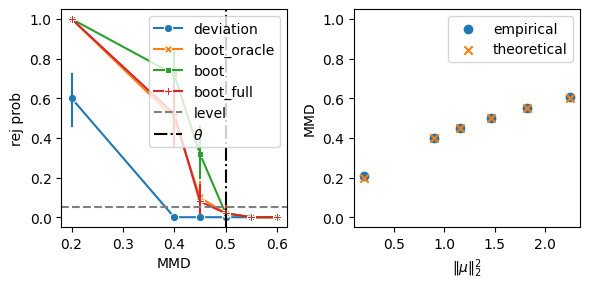

In [285]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
names = ["deviation", "boot_oracle", "boot", "boot_full"]
rej_df = {"rej": [], "method": [], "xaxis": []}
for nn in names:
    for kk in keys:
        rej_ls = res[kk][nn]["rej"]
        rej_df["rej"] = rej_df["rej"] + rej_ls
        rej_df["method"] = rej_df["method"] + [nn] * len(rej_ls)
        rej_df["xaxis"] = rej_df["xaxis"] + [kk] * len(rej_ls)
rej_df = pd.DataFrame(rej_df)

sns.lineplot(ax=ax, data=rej_df, x="xaxis", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()
# ax.legend([],[], frameon=False)

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()
plt.tight_layout()

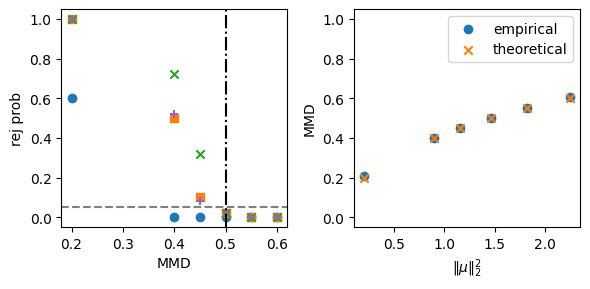

In [250]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="s", label="boot_oracle")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
rej_prob = [np.mean(res[kk]["boot_full"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="+", label="boot_full", color="C4")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
# ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

# ax = axes[2]
# # quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
# # quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
# # ax.scatter(shift_sq_ls, quantile_oracle, label="oracle")
# # ax.scatter(shift_sq_ls, quantile_boot, marker="x", label="boot")
# # # ax.set_xscale("log")
# # ax.set_xlabel(r"$\| \mu \|_2^2$")
# # ax.legend()

# ax.hist(res[keys[0]]["boot"]["boot_stats"][0], bins=50)
# ax.axvline(res[keys[0]]["boot_oracle"]["threshold"][0], color="C0", linestyle="--", label="oracle quantile")
# ax.axvline(res[keys[0]]["boot"]["threshold"][0], color="C1", linestyle="--", label="boot quantile")

_ = plt.tight_layout()
plt.tight_layout()

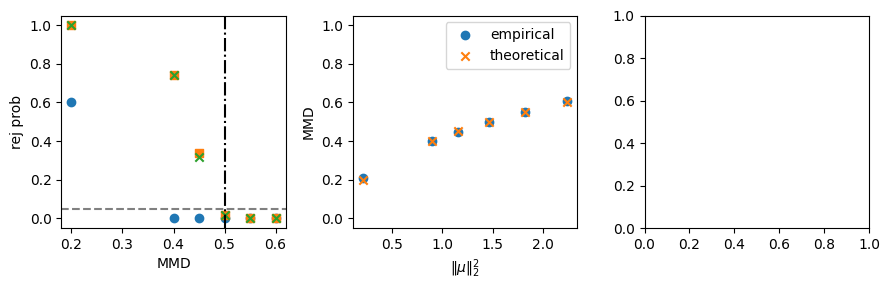

In [207]:
figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, label="deviation")
rej_prob = [np.mean(res[kk]["boot_oracle"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="s", label="boot_oracle")
rej_prob = [np.mean(res[kk]["boot"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob, marker="x", label="boot")
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
# ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, [vv for vv in vals], label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

# ax = axes[2]
# # quantile_oracle = [np.mean(res[kk]["boot_oracle"]["threshold"]) for kk in keys]
# # quantile_boot = [np.mean(res[kk]["boot"]["threshold"]) for kk in keys]
# # ax.scatter(shift_sq_ls, quantile_oracle, label="oracle")
# # ax.scatter(shift_sq_ls, quantile_boot, marker="x", label="boot")
# # # ax.set_xscale("log")
# # ax.set_xlabel(r"$\| \mu \|_2^2$")
# # ax.legend()

# ax.hist(res[keys[0]]["boot"]["boot_stats"][0], bins=50)
# ax.axvline(res[keys[0]]["boot_oracle"]["threshold"][0], color="C0", linestyle="--", label="oracle quantile")
# ax.axvline(res[keys[0]]["boot"]["threshold"][0], color="C1", linestyle="--", label="boot quantile")

_ = plt.tight_layout()
plt.tight_layout()

# Debug bootstrap deviation

In [150]:
def debug_bootstrap(shift_sq_ls, nrep, n, ora_size=None, nstats_ora=100, nboot=100):
    Xs_ls = []
    Ys_ls = []
    stats_all_ls = []

    res = {"shift_sq": shift_sq_ls, "Xs": [], "Ys": [], "quantile": [], "boot_quantile": [], "boot_ora_quantile": [],
           "true_stats": [], "boot_stats": [], "boot_ora_stats": [],
           "Y": []}
    
    for shift_sq in shift_sq_ls:
        print("shift_sq", shift_sq)
        ### Gaussian loc
        mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
        mean2 = np.zeros((dim,))
    
        # Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))

        ora_size = n * 5 if ora_size is None else ora_size
        Y = np.random.multivariate_normal(mean1, np.eye(dim), (ora_size,))
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
        # idx = np.random.choice(n, size=(nrep, n), replace=True) # b, n
        # Xs = Y[idx] # b, n

        Xs = jnp.array(Xs)
        # Ys = jnp.array(Ys)
        ###
    
        Xs_ls.append(Xs)
        # Ys_ls.append(Ys[:nrep])
        # res["Y"] = Y

        # 1. true quantiles
        quantiles = []
        iterator = trange(1)
        for _ in iterator:
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nstats_ora, n))
            # idx = np.random.choice(n, size=(nstats_ora, n), replace=True)
            # Xs = Y[idx]
            
            stat_ls = []
            kernel = kernels.RBF(sigma_sq=2.)
            mmd = metrics.MMD(kernel)
            for i in range(Xs.shape[0]):
                iterator.set_description(f"[{i+1} / {Xs.shape[0]}]")
                X = Xs[i]
                stat_ls.append(mmd(X, Y))
        
            quantile = np.quantile(stat_ls, 0.95)
            quantiles.append(quantile)
            res["true_stats"].append(stat_ls)
        res["quantile"].append(quantiles)

        # 2. bootstrap quantiles
        boot_quantiles = []
        boot_ora_quantiles = []
        kernel = kernels.RBF(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        # for X, Y in tqdm(zip(Xs_ls[-1], Ys_ls[-1]), total=Xs_ls[-1].shape[0]):
        #     # val = mmd(X, Y) # MMD^2 v-stat
        #     boot_stats = mmd.test_threshold(X.shape[0], X, nboot=nboot, method="bootstrap_efron")
        #     boot_stats = np.array(boot_stats)
        #     boot_quantile = np.quantile(boot_stats, 0.95)
        #     boot_quantiles.append(boot_quantile)
        #     res["boot_stats"].append(boot_stats)

        for X in tqdm(Xs_ls[-1], total=Xs_ls[-1].shape[0]):
            boot_stats = mmd.test_threshold(X.shape[0], X, nboot=nboot, method="bootstrap_efron")
            boot_stats = np.array(boot_stats)
            boot_quantile = np.quantile(boot_stats, 0.95)
            boot_quantiles.append(boot_quantile)
            res["boot_stats"].append(boot_stats)

        res["boot_quantile"].append(boot_quantiles)
    
    return res

In [151]:
np.random.seed(2024)

In [152]:
n = 200 # 1000
dim = 1
nrep = 1
# population_mmd_ls = [2e-1, 2.5e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 5.5e-1, 6e-1]
# population_mmd_ls = [4.8e-1, 4.9e-1, 4.95e-1, 5e-1, 5.05e-1, 5.1e-1, 5.2e-1, 5.3e-1]
population_mmd_ls = [0.] # [3e-1, 4e-1, 5e-1, 6e-1]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

keys = population_mmd_ls

# res = debug_bootstrap(shift_sq_ls, nrep=nrep, n=n, ora_size=20000, nboot=500, nstats_ora=500)
res_boot = debug_bootstrap(shift_sq_ls, nrep=nrep, n=n, ora_size=5000, nboot=500, nstats_ora=500)

shift_sq -0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [94]:
# import pickle 
# pickle.dump(res, open("../res/reversed/boot_res.pkl", "wb"))
# pickle.dump(res, open("../res/reversed/boot_res_empirical.pkl", "wb"))

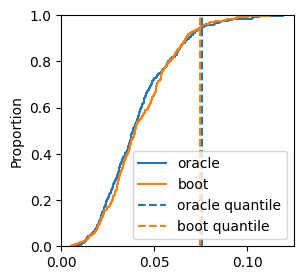

In [175]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0])**0.5, label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0])**0.5, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

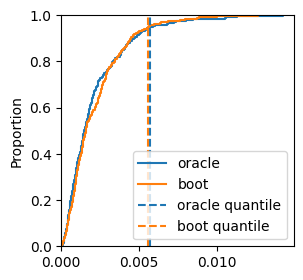

In [178]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res_boot["true_stats"][0]), label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res_boot["boot_stats"][0]), label="boot")
ax.axvline(ora_quantile[0], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0], color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

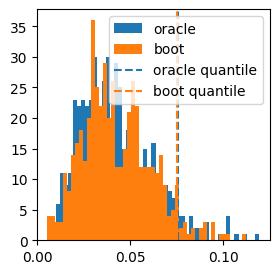

In [157]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
ax.hist(np.array(res_boot["true_stats"][0])**0.5, bins=50, label="oracle")
ax.hist(np.array(res_boot["boot_stats"][0])**0.5, bins=50, label="boot")
ax.axvline(ora_quantile[0]**0.5, color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0]**0.5, color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

In [166]:
print("oracle", ora_quantile[0]**0.5)
print("boot  ", boot_quantile[0]**0.5)

oracle 0.07562418913603572
boot   0.07491267206435458


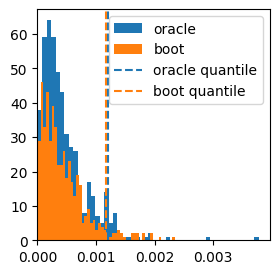

In [116]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res_boot["quantile"]]
boot_quantile = [np.mean(r) for r in res_boot["boot_quantile"]]
ax.hist(res_boot["true_stats"][0], bins=50, label="oracle")
ax.hist(res_boot["boot_stats"][0], bins=50, label="boot")
# ax.hist(res["boot_ora_stats"][0], bins=10, label="boot_ora")
# test_stat_oracle = np.mean(res["true_stats"][0])
# ax.hist(res["boot_stats"][0] - test_stat_oracle, bins=10, label="boot")
ax.axvline(ora_quantile[0], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[0], color="C1", linestyle="--", label="boot quantile")
ax.set_xlim(0)

ax.legend()

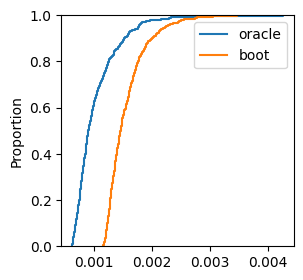

In [86]:
# CDF of stats
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
sns.ecdfplot(ax=ax, data=np.array(res["true_stats"][0]), label="oracle")
sns.ecdfplot(ax=ax, data=np.array(res["boot_stats"][0]), label="boot")

ax.legend()

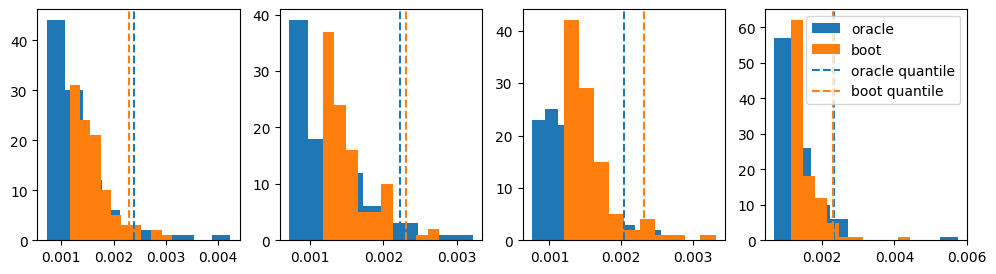

In [241]:
# CDF of stats
figs, axes = plt.subplots(ncols=len(res["quantile"]), nrows=1, figsize=(len(res["quantile"])*3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
for i, ax in enumerate(axes.flatten()):
    ax.hist(res["true_stats"][i], bins=10, label="oracle")
    ax.hist(res["boot_stats"][i], bins=10, label="boot")
    ax.axvline(ora_quantile[i], color="C0", linestyle="--", label="oracle quantile")
    ax.axvline(boot_quantile[i], color="C1", linestyle="--", label="boot quantile")

ax.legend()

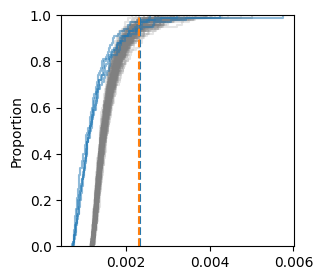

In [253]:
# CDF of stats
figs, axes = plt.subplots(ncols=1, nrows=1, figsize=(3, 3))

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]

ax = axes
for i in range(100):
    sns.ecdfplot(ax=ax, data=np.array(res["boot_stats"][i]), label="boot", alpha=0.2, color="grey")

for i in range(4):
    sns.ecdfplot(ax=ax, data=np.array(res["true_stats"][i]), label="oracle", alpha=0.5, color="C0")

ax.axvline(ora_quantile[i], color="C0", linestyle="--", label="oracle quantile")
ax.axvline(boot_quantile[i], color="C1", linestyle="--", label="boot quantile")
    
# ax.legend()

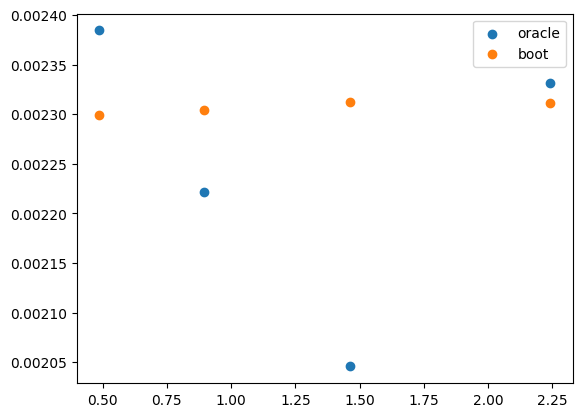

In [239]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
ax.legend()

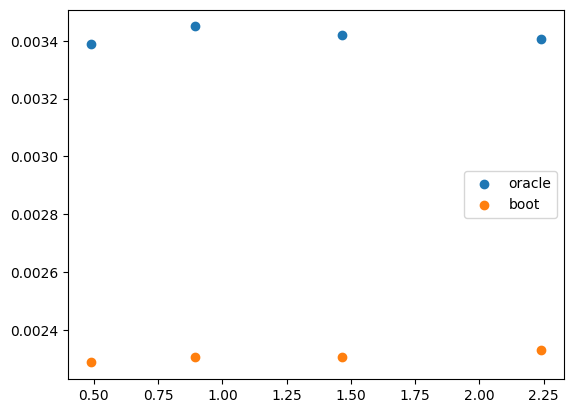

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
ax.legend()

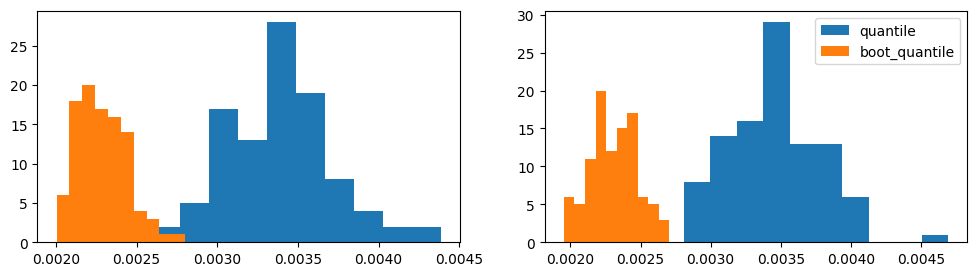

In [182]:
# CDF of quantiles
figs, axes = plt.subplots(ncols=len(res["quantile"]), nrows=1, figsize=(len(res["quantile"])*3, 3))

for i, ax in enumerate(axes.flatten()):
    ax.hist(res["quantile"][i], bins=10, label="quantile")
    ax.hist(res["boot_quantile"][i], bins=10, label="boot_quantile")

ax.legend()

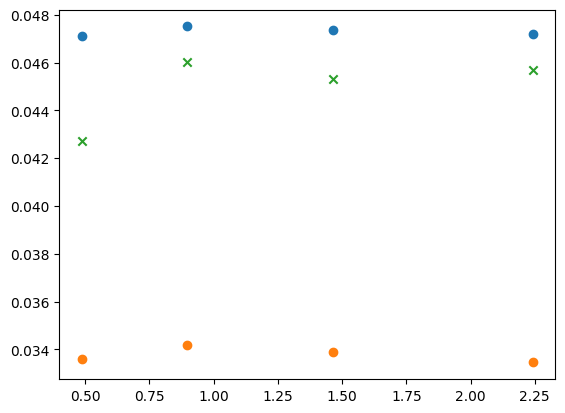

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ora_quantile = [np.mean(r) for r in res["quantile"]]
boot_quantile = [np.mean(r) for r in res["boot_quantile"]]
boot_ora_quantile = [np.mean(r) for r in res["boot_ora_quantile"]]
_ = ax.scatter(res["shift_sq"], ora_quantile, label="oracle")
_ = ax.scatter(res["shift_sq"], boot_quantile, label="boot")
_ = ax.scatter(res["shift_sq"], boot_ora_quantile, marker="x", label="boot_ora")
ax.legend()

In [157]:
np.sqrt(0.95 * 0.05 / 1000)

0.006892024376045111